# データ入力

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
import sklearn.metrics as sm

df = pd.read_csv("energydata.csv")

# 分位数を指定して外れ値を削除
df = df[df['Appliances'].between(df['Appliances'].quantile(.0), df['Appliances'].quantile(.98))]

# 対数変換
df['log_appliances'] = np.log(df.Appliances)

# 新たな列を追加
# 年月日
df["split_date"]=df['date'].str.split(' ').str[0]

# 時間、分単位
df["hours"]=(df['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
df["seconds"]=((df['date'].str.split(':').str[1])).astype(str).astype(int).mul(60)

# 1週毎
df["week"]=(df['date'].str.split(' ').str[0])
df["week"]=(df['week'].apply(dateutil.parser.parse, dayfirst=True))
df["weekday"]=(df['week'].dt.dayofweek).astype(str).astype(int)
df["week"]=(df['week'].dt.day_name())

# 特徴量の追加と選択

In [25]:
# 時間ごとの平均使用量
df['hour_avg'] = list(map(dict(df.groupby('hours')["Appliances"].mean()).get, df.hours))

# 交互作用特徴量：時間 × ライト
df['hour*lights'] = df.hours * df.lights

# 平均値より高消費、低消費
df['low_consum'] = (df.Appliances<(df.hour_avg))*1
df['high_consum'] = (df.Appliances>(df.hour_avg))*1

df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,log_appliances,split_date,hours,seconds,week,weekday,hour_avg,hour*lights,low_consum,high_consum
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,4.094345,2016-01-11,17,0,Tuesday,1,130.724450,510,1,0
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,4.094345,2016-01-11,17,600,Tuesday,1,130.724450,510,1,0
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,3.912023,2016-01-11,17,1200,Tuesday,1,130.724450,510,1,0
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,3.912023,2016-01-11,17,1800,Tuesday,1,130.724450,680,1,0
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,4.094345,2016-01-11,17,2400,Tuesday,1,130.724450,680,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,4.605170,2016-05-27,17,1200,Friday,4,130.724450,0,1,0
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,4.499810,2016-05-27,17,1800,Friday,4,130.724450,0,1,0
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,5.598422,2016-05-27,17,2400,Friday,4,130.724450,170,0,1
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,6.040255,2016-05-27,17,3000,Friday,4,130.724450,170,0,1


In [26]:
# 1時間単位のデータセットに変換
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df_hour = df.resample('1H').mean()
df_hour['low_consum'] = (df_hour.Appliances<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.Appliances>(df_hour.hour_avg))*1

df_hour

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,rv1,rv2,log_appliances,hours,seconds,weekday,hour_avg,hour*lights,low_consum,high_consum
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,55.000000,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,...,26.823044,26.823044,4.003184,17.0,1500.0,1.0,130.724450,595.000000,1,0
2016-01-11 18:00:00,96.000000,50.000000,19.864000,45.775500,19.237333,44.446667,19.766000,44.870667,18.890000,45.994000,...,25.023480,25.023480,4.393922,18.0,1200.0,1.0,152.822903,900.000000,1,0
2016-01-11 19:00:00,173.333333,25.000000,20.495556,52.805556,19.925556,46.061667,20.052222,47.227361,18.969444,47.815556,...,33.734932,33.734932,4.923982,19.0,1500.0,1.0,131.359102,475.000000,0,1
2016-01-11 20:00:00,125.000000,35.000000,20.961111,48.453333,20.251111,45.632639,20.213889,47.268889,19.190833,49.227917,...,25.679642,25.679642,4.793191,20.0,1500.0,1.0,119.491945,700.000000,0,1
2016-01-11 21:00:00,103.333333,23.333333,21.311667,45.768333,20.587778,44.961111,20.373333,46.164444,19.425556,47.918889,...,18.826274,18.826274,4.636940,21.0,1500.0,1.0,94.315403,490.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,101.666667,1.666667,25.544444,46.638889,26.421369,41.205054,28.397778,41.160000,24.666667,45.883889,...,27.553946,27.553946,4.497876,14.0,1500.0,4.0,97.723881,23.333333,0,1
2016-05-27 15:00:00,76.666667,0.000000,25.500000,45.677639,26.154762,41.041238,28.240000,40.306667,24.694444,45.270000,...,25.429025,25.429025,4.326760,15.0,1500.0,4.0,95.724907,0.000000,1,0
2016-05-27 16:00:00,135.000000,0.000000,25.487778,46.250000,26.000000,41.736190,27.953333,40.607778,24.700000,45.476667,...,23.229344,23.229344,4.847371,16.0,1500.0,4.0,104.993726,0.000000,0,1


In [27]:
# 使用する特徴量を選択
feature_set = ['low_consum','high_consum','hours','T6','RH_6','lights','hour*lights',
               'Tdewpoint','Visibility','Press_mm_hg','Windspeed']

# 機械学習モデルの作成

In [28]:
# カテゴリカル変数の変換
for cat_feature in ['weekday', 'hours']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df = pd.concat([df, pd.get_dummies(df[cat_feature])], axis=1)

In [29]:
# 型を揃える
df_hour.lights = df_hour.lights.astype(float)
df_hour.log_appliances = df_hour.log_appliances.astype(float)
df_hour.hour = df_hour.hours.astype(float)
df_hour.low_consum = df_hour.low_consum.astype(float)
df_hour.high_consum = df_hour.high_consum.astype(float)

c:\users\hiroa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [30]:
# トレーニング/テストセットの作成
test_size=0.2
test_index = int(len(df_hour.dropna())*(1-test_size))
X_train, X_test = df_hour[feature_set].iloc[:test_index,], df_hour[feature_set].iloc[test_index:,]
y_train = df_hour.log_appliances.iloc[:test_index,]
y_test =  df_hour.log_appliances.iloc[test_index:,]

In [31]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100,random_state=1)            
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

# Function to evaluate the models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    r_score = 100*r2_score(test_labels,predictions)
    accuracy = 100 - mape
    print(model,'\n')
    print('Average Error       : {:0.4f} degrees'.format(np.mean(errors)))
    print('Variance score R^2  : {:0.2f}%' .format(r_score))
    print('Accuracy            : {:0.2f}%\n'.format(accuracy))

evaluate(rf_model, X_test, y_test)

RandomForestRegressor(random_state=1) 

Average Error       : 0.1814 degrees
Variance score R^2  : 69.88%
Accuracy            : 95.89%



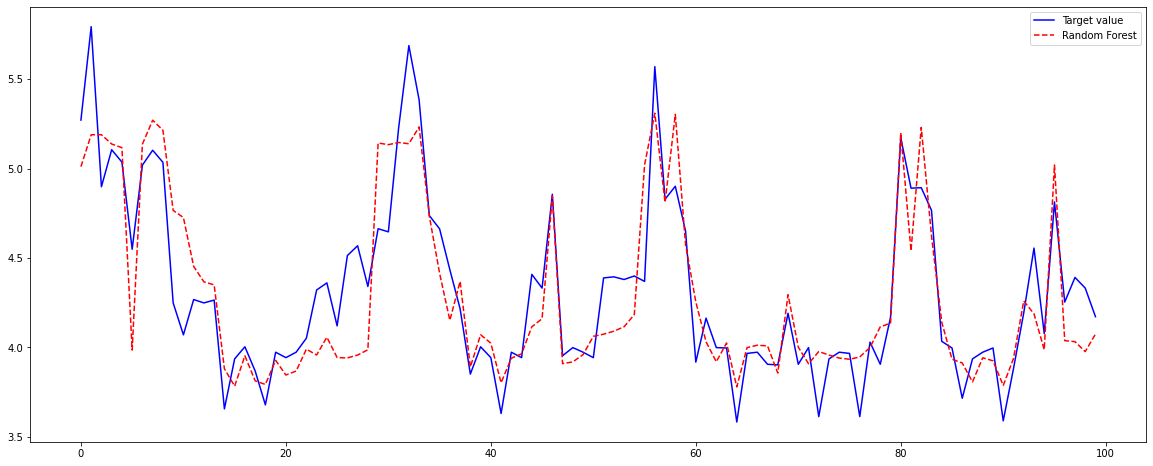

In [34]:
# 予測値とテスト値をグラフ化
y_pred = rf_model.predict(X_test)

fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:100].values,label='Target value',color='b')
plt.plot(y_pred[:100],label='Random Forest', linestyle='--', color='r')
plt.legend(loc=1)

# 誤差が大きい時間帯の考察

In [35]:
# 予測結果との差を計算
y_test_ = pd.DataFrame(y_test)
y_test_ = y_test_.reset_index()
y_pred_ = pd.DataFrame(y_pred,columns = ["pred"])
y_concat = pd.concat([y_test_, y_pred_], axis=1)
y_concat['Error'] = (y_concat['log_appliances'] - y_concat['pred']).abs()
y_concat


,date,log_appliances,pred,Error
0,2016-04-30 09:00:00,5.271151,5.010790,0.260361
1,2016-04-30 10:00:00,5.793505,5.189088,0.604418
2,2016-04-30 11:00:00,4.898321,5.189394,0.291073
3,2016-04-30 12:00:00,5.105270,5.137333,0.032063
4,2016-04-30 13:00:00,5.036060,5.116678,0.080618
...,...,...,...,...
653,2016-05-27 14:00:00,4.497876,5.140381,0.642504
654,2016-05-27 15:00:00,4.326760,4.188575,0.138184
655,2016-05-27 16:00:00,4.847371,5.145189,0.297818
656,2016-05-27 17:00:00,4.990658,5.176529,0.185872


In [36]:
# 誤差の大きい順にソート
y_concat.sort_values(by = 'Error',ascending=False,inplace=True)

# 年月日と時間を分割し時間列を作成
y_concat['date'] = y_concat['date'].astype(str)
y_concat["exact_date"]=y_concat['date'].str.split(' ').str[0]

# 時間列に時間の数値を追加
y_concat["hours"]=(y_concat['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
y_concat.head(20)


,date,log_appliances,pred,Error,exact_date,hours
439,2016-05-18 16:00:00,4.487607,5.375594,0.887988,2016-05-18,16
478,2016-05-20 07:00:00,4.379402,5.200597,0.821195,2016-05-20,7
262,2016-05-11 07:00:00,4.330196,5.061192,0.730996,2016-05-11,7
146,2016-05-06 11:00:00,4.489635,5.216144,0.726509,2016-05-06,11
201,2016-05-08 18:00:00,3.898416,4.621459,0.723043,2016-05-08,18
657,2016-05-27 18:00:00,6.063785,5.341363,0.722422,2016-05-27,18
534,2016-05-22 15:00:00,4.568375,5.277276,0.708901,2016-05-22,15
202,2016-05-08 19:00:00,4.070761,4.774140,0.703378,2016-05-08,19
578,2016-05-24 11:00:00,4.619380,3.945269,0.674112,2016-05-24,11
193,2016-05-08 10:00:00,4.536975,5.207091,0.670116,2016-05-08,10


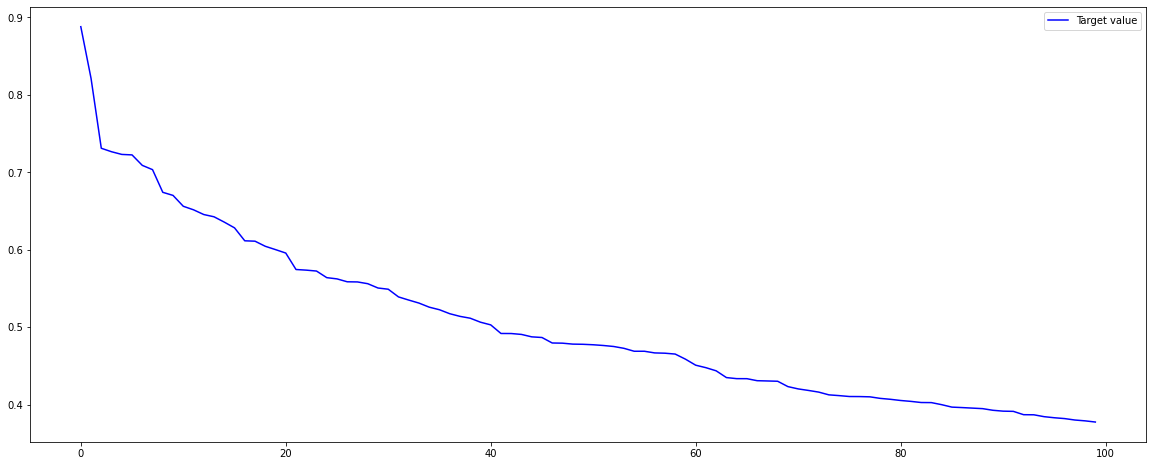

In [37]:
# 誤差をグラフ表示
fig = plt.figure(figsize=(20,8))
plt.plot(y_concat["Error"][:100].values,label='Target value',color='b')
plt.legend(loc=1)


<AxesSubplot:xlabel='hours', ylabel='Count'>

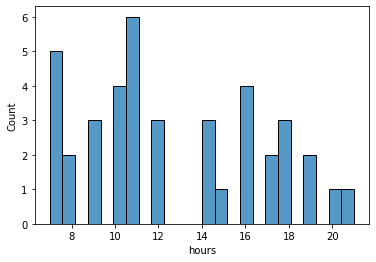

In [38]:
# 誤差の大きい時間帯を抽出(40件)
y_error = y_concat[y_concat['Error'].between(y_concat['Error'].quantile(618/658), y_concat['Error'].quantile(1.0))]
# ヒストグラム表示
sns.histplot(y_error["hours"],bins=24)